# Plot VNC for Flat Earth Subreddits

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import sqlite3
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from nltk import ngrams as make_ngrams
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from helpers import load_posts, load_toks, load_pos, get_top_n_toks
from language_change_methods.vnc import VNC, plot_vnc
from language_change_methods.utility_functions import get_data_windows, get_time_windows, basic_preprocessing
from language_change_methods.features import get_tok_counts, function_words, combine_counts, make_feature_matrix

# This method calculates cosine distance between two vectors.
from scipy.spatial.distance import cosine as cosine_dist
# This method simply inverts it to get similarity.
cosine_sim = lambda x,y: 1 - cosine_dist(x,y)

from sklearn.metrics import jaccard_score

convert_to_date = lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S")

from settings import FE_REDDIT_DIR as SUBREDDITS_FP
TOKENS_FP = os.path.join(SUBREDDITS_FP, "COMMENTS")
OUT_DIR = "./Graphs"

In [2]:
window_sizes = {"DebateFlatEarth": 1100, 
                "flatearth": 47000, 
                "FlatEarthIsReal": 500, 
                "flatearthsociety": 1600, 
                "Flat_Earth": 2600, 
                "Globeskeptic": 1400, 
                "notaglobe": 2500, 
                "theworldisflat": 2000}

In [3]:
def read_subreddit(db_fp):
    conn = sqlite3.connect(db_fp)
    comments = pd.read_sql_query("SELECT uid, time, body FROM comments", conn)
    comments.set_index("uid", inplace=True)
    comments['time'] = comments['time'].apply(convert_to_date)
    comments.sort_values("time", inplace=True)
    comments = comments.query("body != '[removed]' and body != '[deleted]'")
    return comments

In [4]:
def get_bow_counts(curr_toks):
    bow_counts = {i: get_tok_counts(post) for i, post in curr_toks.items()}
    bow_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in bow_counts.items()}
    top_n = get_top_n_toks(bow_counts.values(), 1000)
    bow_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in bow_counts.items()}
    bow_counts = pd.Series(bow_counts)
    return bow_counts

In [5]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

In [6]:
def make_subreddit_vnc(curr_fp, curr_name, tok_fp):
    comments = read_subreddit(curr_fp)
            
    toks = {x[0]: x[1] for x in load_toks(tok_fp)}
    toks = pd.Series(toks)
    toks = toks[toks.index.isin(comments.index)]
    comments = comments.loc[toks.index]

    window_toks = {curr_date: merge_lists(toks.loc[curr_window.index]) 
                   for curr_date, curr_window in get_data_windows(comments, 
                                                                  window_sizes[curr_name], 
                                                                  window_sizes[curr_name])}
    window_toks = pd.Series(window_toks)

    # Get the counts
    curr_counts = get_bow_counts(window_toks)

    # Make the feature matrix
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    norm_feats = curr_feats / window_toks.apply(len).values[:,None]

    feats = StandardScaler().fit_transform(norm_feats)
    feats = pd.DataFrame(feats, index=curr_counts.index, columns=curr_feat_names)

    print("-----------------------------------------------------------------")
    print(curr_name)
    print("-----------------------------------------------------------------")

    vnc = VNC(feats, cosine_sim)
    c, coph_dists = cophenet(vnc.d_list, pdist(feats, metric="cosine"))
    print("Cophenetic Correlation Coefficient: {}".format(c))

    fig, ax = plt.subplots(figsize=(6,6))
    vnc.draw_dendrogram(ax=ax, colour="blue")
    ax.grid()
    plt.show()
    return vnc

C:/Users/Eddie/Documents/Datasets/Reddit/FE\DebateFlatEarth\DebateFlatEarth.db
-----------------------------------------------------------------
DebateFlatEarth
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.8773340866378752


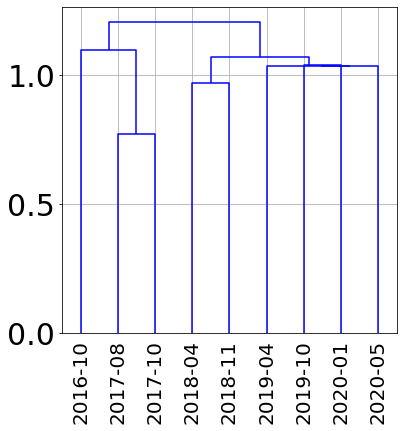

Time taken:  0:00:02.561945
C:/Users/Eddie/Documents/Datasets/Reddit/FE\flatearth\flatearth.db
-----------------------------------------------------------------
flatearth
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.8953910852027465


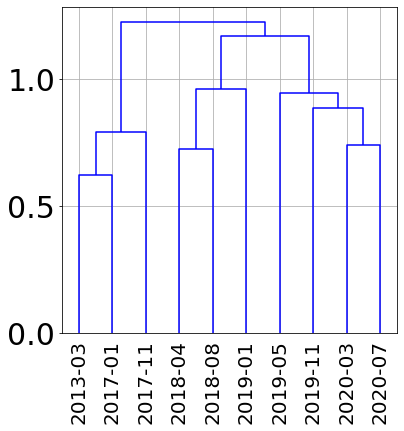

Time taken:  0:00:43.429386
C:/Users/Eddie/Documents/Datasets/Reddit/FE\FlatEarthIsReal\FlatEarthIsReal.db
-----------------------------------------------------------------
FlatEarthIsReal
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.7594765992804646


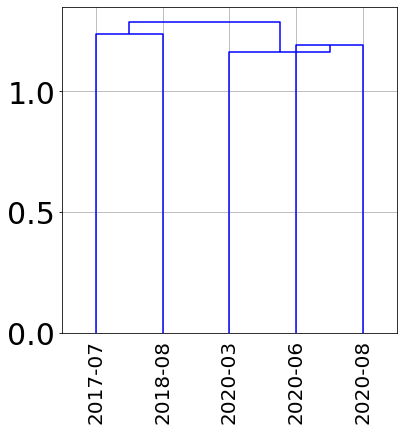

Time taken:  0:00:00.612608
C:/Users/Eddie/Documents/Datasets/Reddit/FE\flatearthsociety\flatearthsociety.db
-----------------------------------------------------------------
flatearthsociety
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.7979088921767


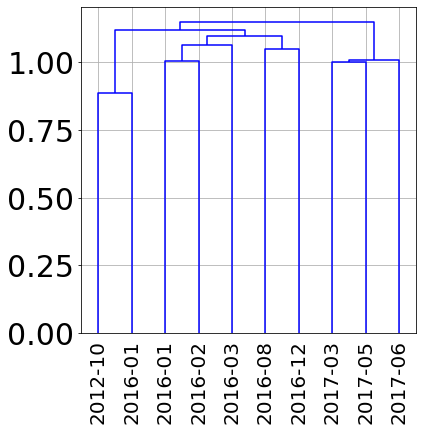

Time taken:  0:00:02.094358
C:/Users/Eddie/Documents/Datasets/Reddit/FE\Flat_Earth\Flat_Earth.db
-----------------------------------------------------------------
Flat_Earth
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.6445984763197209


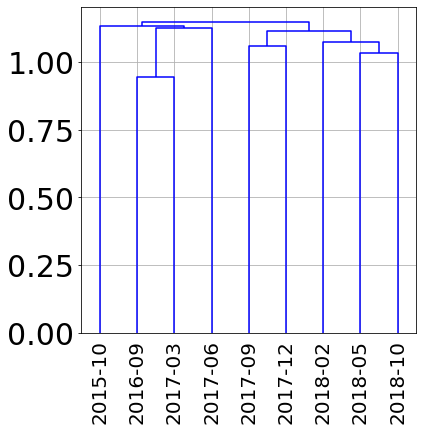

Time taken:  0:00:03.445187
C:/Users/Eddie/Documents/Datasets/Reddit/FE\Globeskeptic\Globeskeptic.db
-----------------------------------------------------------------
Globeskeptic
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.7786234477828818


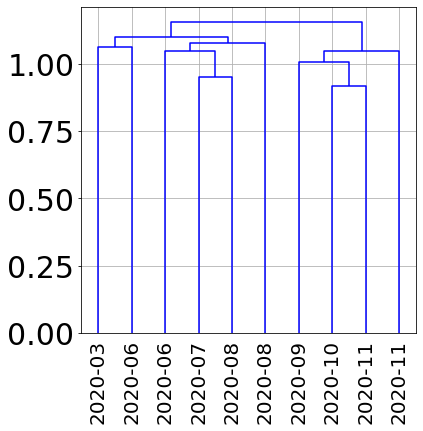

Time taken:  0:00:02.218710
C:/Users/Eddie/Documents/Datasets/Reddit/FE\notaglobe\notaglobe.db
-----------------------------------------------------------------
notaglobe
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.9287128094756506


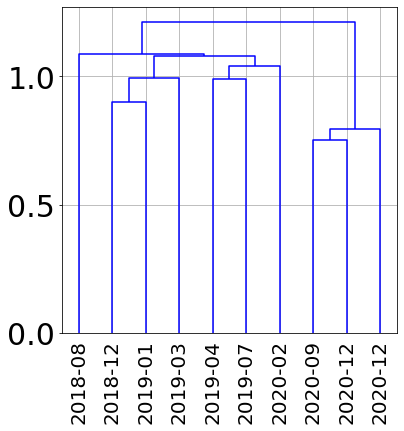

Time taken:  0:00:03.344223
C:/Users/Eddie/Documents/Datasets/Reddit/FE\theworldisflat\theworldisflat.db
-----------------------------------------------------------------
theworldisflat
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.8015064550291724


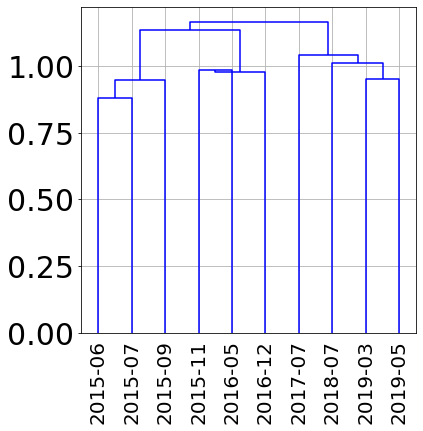

Time taken:  0:00:03.273430
Wall time: 1min 1s


In [7]:
%%time

vnc_dic = dict()

for subdir, dirs, files in os.walk(SUBREDDITS_FP):
        for filename in files:
            if not filename.endswith(".db"):
                continue
                
            curr_fp = os.path.join(subdir, filename)
            curr_name = filename[:-3]
            print(curr_fp)
            
            tok_fp = os.path.join(TOKENS_FP, f"{curr_name}_comments.json")
            
            startTime = datetime.now()
            vnc_dic[curr_name] = make_subreddit_vnc(curr_fp, curr_name, tok_fp)
            print("Time taken: ", datetime.now() - startTime)

## Make a plot of the clusters for each sub

In [8]:
cluster_dic = {n: v.get_clusters(1) for n, v in vnc_dic.items()}
window_dic = {n: v.matrix.index for n, v in vnc_dic.items()}

In [9]:
cluster_dic

{'DebateFlatEarth': array([2, 1, 1, 3, 3, 7, 4, 5, 6], dtype=int32),
 'flatearth': array([1, 1, 1, 2, 2, 2, 3, 3, 3, 3], dtype=int32),
 'FlatEarthIsReal': array([1, 2, 5, 3, 4], dtype=int32),
 'flatearthsociety': array([1, 1, 2, 3, 4, 5, 6, 7, 7, 8], dtype=int32),
 'Flat_Earth': array([3, 1, 1, 2, 4, 5, 8, 6, 7], dtype=int32),
 'Globeskeptic': array([1, 2, 4, 3, 3, 5, 7, 6, 6, 8], dtype=int32),
 'notaglobe': array([4, 1, 1, 1, 2, 2, 3, 5, 5, 5], dtype=int32),
 'theworldisflat': array([1, 1, 1, 2, 2, 2, 5, 4, 3, 3], dtype=int32)}

In [10]:
window_dic

{'DebateFlatEarth': DatetimeIndex(['2016-10-12 21:36:26', '2017-08-24 20:26:30',
                '2017-10-03 18:10:32', '2018-04-20 06:08:51',
                '2018-11-23 05:27:21', '2019-04-12 16:47:40',
                '2019-10-17 07:21:03', '2020-01-29 06:52:44',
                '2020-05-29 21:14:48'],
               dtype='datetime64[ns]', freq=None),
 'flatearth': DatetimeIndex(['2013-03-15 19:22:59', '2017-01-22 01:29:09',
                '2017-11-15 01:53:37', '2018-04-28 17:31:55',
                '2018-08-03 01:02:18', '2019-01-07 23:23:07',
                '2019-05-19 18:22:36', '2019-11-09 17:05:16',
                '2020-03-05 17:53:14', '2020-07-07 19:36:34'],
               dtype='datetime64[ns]', freq=None),
 'FlatEarthIsReal': DatetimeIndex(['2017-07-18 05:31:38', '2018-08-05 20:14:09',
                '2020-03-05 06:35:46', '2020-06-02 00:22:01',
                '2020-08-27 22:05:37'],
               dtype='datetime64[ns]', freq=None),
 'flatearthsociety': DatetimeInde

In [11]:
test = cluster_dic["flatearth"]

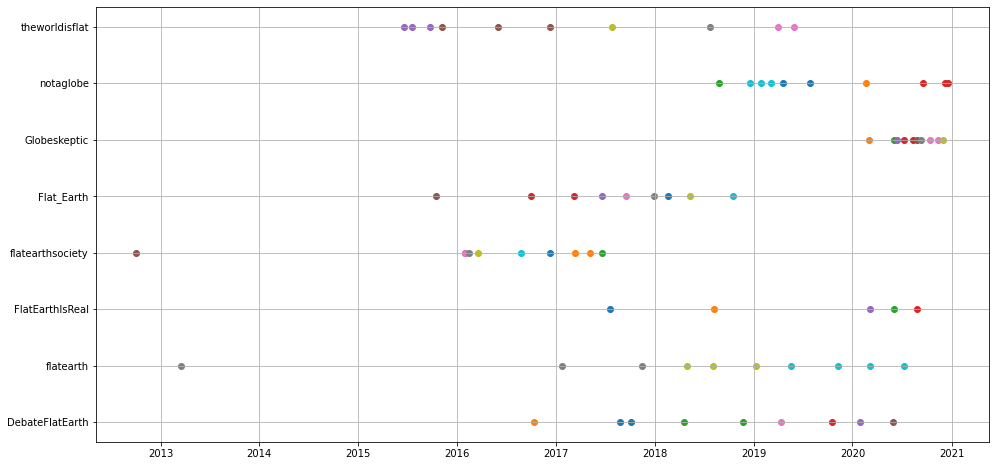

In [12]:
fig, ax = plt.subplots(figsize=(16,8))

for i, name in enumerate(cluster_dic):
    clusts = cluster_dic[name]
    dates = window_dic[name]
    
    for clust in set(clusts):
        x = dates[clusts==clust]
        y = [i] * len(clusts[clusts==clust])
        ax.scatter(x, y)
        
ax.set_yticks(list(range(0,len(cluster_dic))))
ax.set_yticklabels(list(cluster_dic))        

ax.grid()
plt.show()

In [13]:
list(cluster_dic)

['DebateFlatEarth',
 'flatearth',
 'FlatEarthIsReal',
 'flatearthsociety',
 'Flat_Earth',
 'Globeskeptic',
 'notaglobe',
 'theworldisflat']

In [99]:
%%time
def ax_epochs_against_posts(times, counts, clust_starts, ax):
    ax.plot(times, counts, c="#7fbf7b", lw=3)
    for c_start in clust_starts:
        ax.axvline(c_start, c="#af8dc3", linestyle="--", lw=3)

    for tick in ax.xaxis.get_ticklabels():
        tick.set_size(14)

    for tick in ax.yaxis.get_ticklabels():
        tick.set_size(14)

    ax.grid()

Wall time: 0 ns


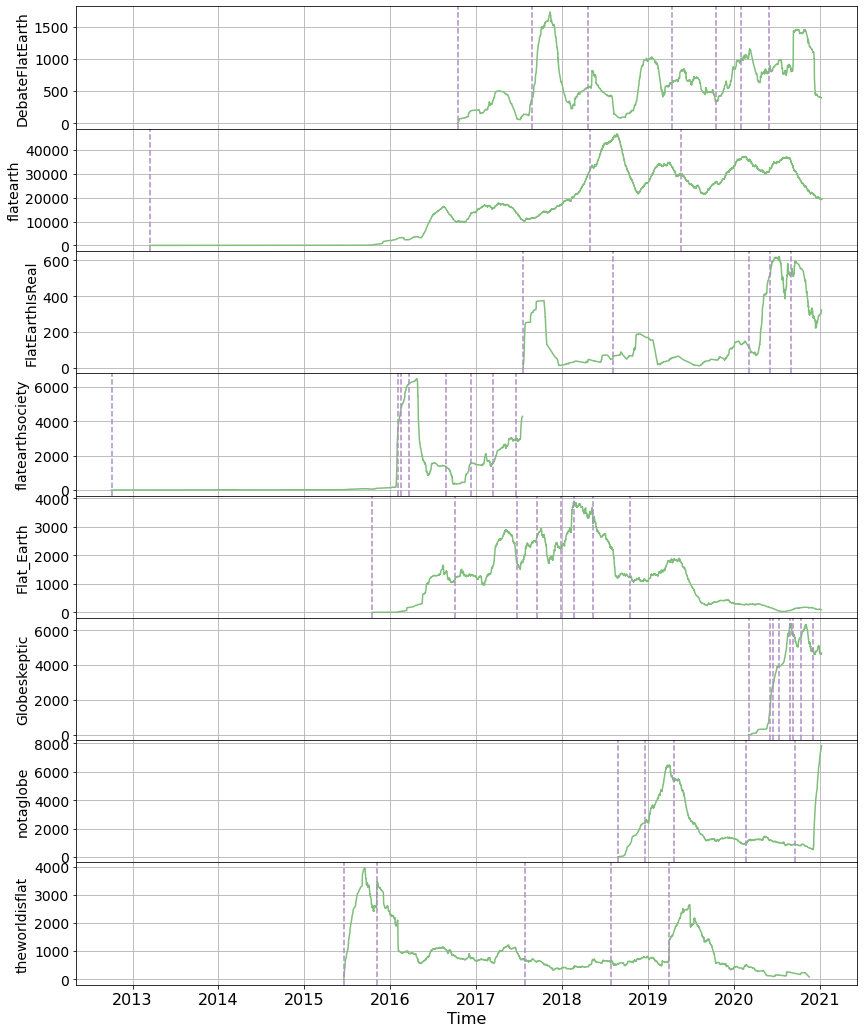

Wall time: 8.25 s


In [94]:
%%time
fig = plt.figure(figsize=(14, 18))
gs = fig.add_gridspec(len(cluster_dic), hspace=0)
axes = gs.subplots(sharex=True)

# to_plot = ["flatearth", "flatearthsociety", ""]

for i, name in enumerate(cluster_dic):
    clusts = cluster_dic[name]
    dates = window_dic[name]
    curr_fp = os.path.join(SUBREDDITS_FP, name, f"{name}.db")
    comments = read_subreddit(curr_fp)
    comments["flag"] = [True] * len(comments)
    
    clust_starts = [dates[clusts==c][0] for c in set(clusts)]
    rolling_counts = comments.rolling("90D", on="time").count()
    ax_epochs_against_posts(rolling_counts["time"], rolling_counts["flag"], clust_starts, axes[i]) 
    axes[i].set_ylabel(name, size=14)
    
    plt.setp(axes[i].get_yticklabels(), fontsize=14)
    
axes[-1].set_xlabel("Time", size=16)
plt.setp(axes[-1].get_xticklabels(), fontsize=16)
fig.savefig(os.path.join(OUT_DIR, "fe_reddit_comments_vnc_meta.pdf"))
plt.show()

In [92]:
clust_levels = {"DebateFlatEarth": 1.1, "flatearth": 1, "FlatEarthIsReal": 1.25, "flatearthsociety": 1.1, 
                "Flat_Earth": 1.1, "Globeskeptic": 1.1, "notaglobe": 1.1, "theworldisflat": 1.1}

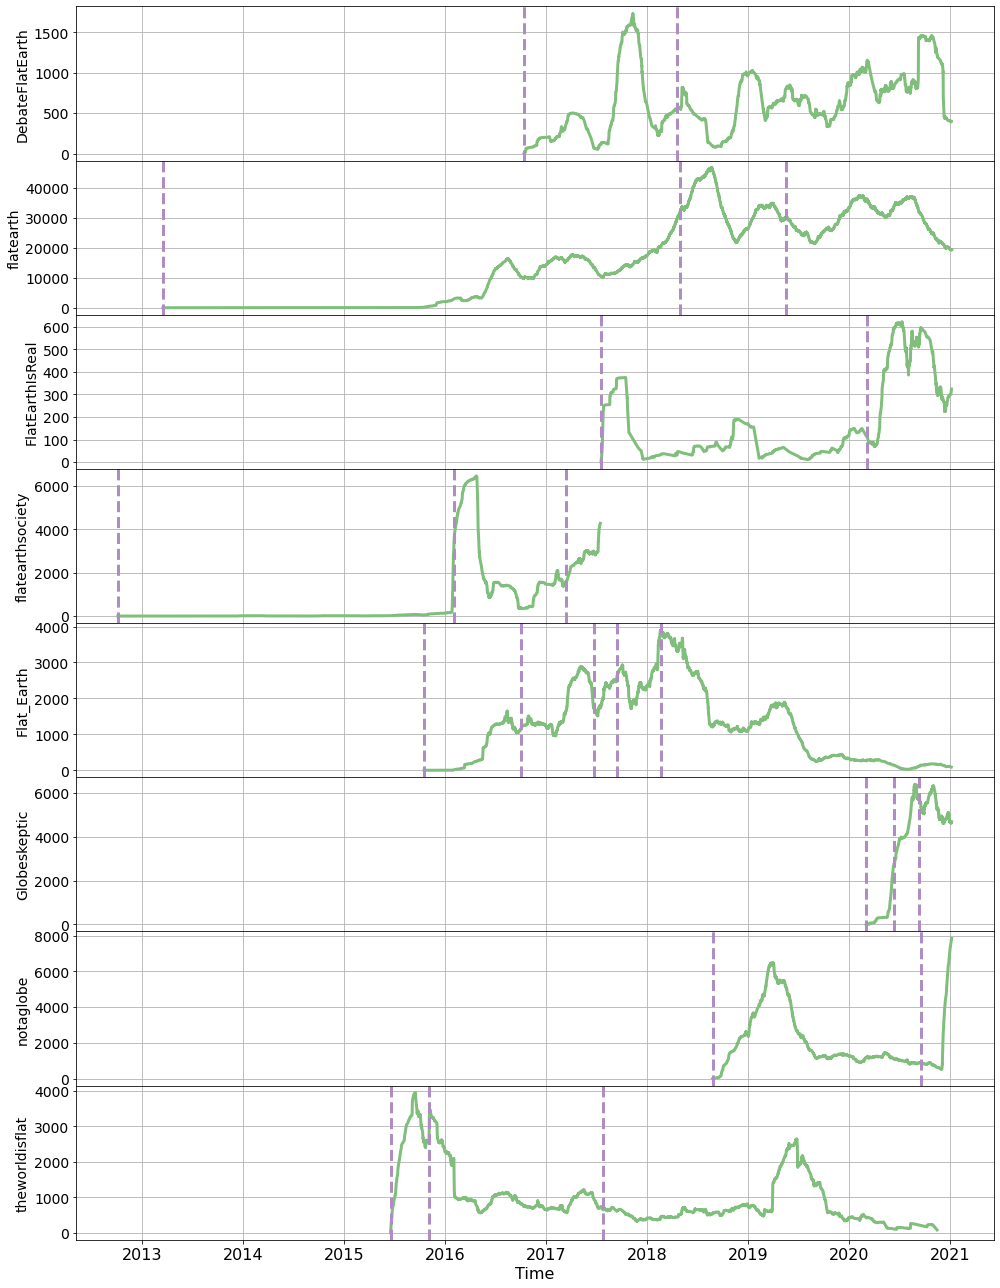

Wall time: 8.16 s


In [101]:
%%time
fig = plt.figure(figsize=(14, 18))
gs = fig.add_gridspec(len(cluster_dic), hspace=0)
axes = gs.subplots(sharex=True)

# to_plot = ["flatearth", "flatearthsociety", ""]

for i, name in enumerate(cluster_dic):
    clusts = renumber_cluster(vnc_dic[name].get_clusters(clust_levels[name]))
    dates = window_dic[name]
    curr_fp = os.path.join(SUBREDDITS_FP, name, f"{name}.db")
    comments = read_subreddit(curr_fp)
    comments["flag"] = [True] * len(comments)
    
    clust_starts = [dates[clusts==c][0] for c in set(clusts)]
    rolling_counts = comments.rolling("90D", on="time").count()
    ax_epochs_against_posts(rolling_counts["time"], rolling_counts["flag"], clust_starts, axes[i]) 
    axes[i].set_ylabel(name, size=14)
    
    plt.setp(axes[i].get_yticklabels(), fontsize=14)
    
axes[-1].set_xlabel("Time", size=16)
plt.setp(axes[-1].get_xticklabels(), fontsize=16)
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "fe_reddit_comments_vnc_meta.pdf"))
plt.show()

# Plot the keywords for each

In [77]:
from features import get_ngram_lr_and_ll
from word_clouds import make_wordcloud

def renumber_cluster(clusts):
    c_list = []
    c_map = dict()
    n_clusts = []
    for c in clusts:
        if c not in c_list:
            c_list.append(c)
            c_map[c] = len(c_list)
        n_clusts.append(c_map[c])
    return np.array(n_clusts)

def plot_cluster_kw(clusters, window_posts, toks, clust_windows, min_freq=100, before_comparison=False):
    num_clusts = len(set(clusters))
    fig, axes = plt.subplots(1, num_clusts, figsize=(10*num_clusts, 8))
    
    kw_dic = dict()
    for i, clust in enumerate(set(clusters)):
        curr_clust_windows = clust_windows[clusters == clust]
        clust_indices = merge_lists([window_posts[w] for w in curr_clust_windows])
        clust_toks = toks.loc[clust_indices]
        pre_clust_windows=[]
        if not before_comparison:
            non_clust_toks = toks[~toks.index.isin(clust_indices)]
        else:
            pre_clust_windows = clust_windows[clust_windows < min(clust_windows[clusters==clust])]
            pre_clust_indices = merge_lists([window_posts[w] for w in pre_clust_windows])
            non_clust_toks = toks.loc[pre_clust_indices]
        
        if not (len(pre_clust_windows)== 0 and before_comparison):
            kw = get_ngram_lr_and_ll(clust_toks, non_clust_toks, 1, "_")
    #         kw = kw.query("LR > 1 and freq1 > 100").sort_values("LR", ascending=False).head(100)["LR"]
            kw = kw.query(f"LR > 1 and freq1 > {min_freq}").sort_values("LR", ascending=False).head(100)["LR"]
            kw_dic[clust] = kw

            if len(kw):
                cloud = make_wordcloud(kw)
                axes[i].imshow(cloud, aspect="auto")
        
        axes[i].axes.xaxis.set_ticks([])
        axes[i].axes.yaxis.set_ticks([])
        axes[i].set_title("\n".join([x.strftime("%Y/%m/%d") for x in curr_clust_windows]), fontsize=30)
        
    plt.show()
    return kw_dic

-------------------------------
DebateFlatEarth


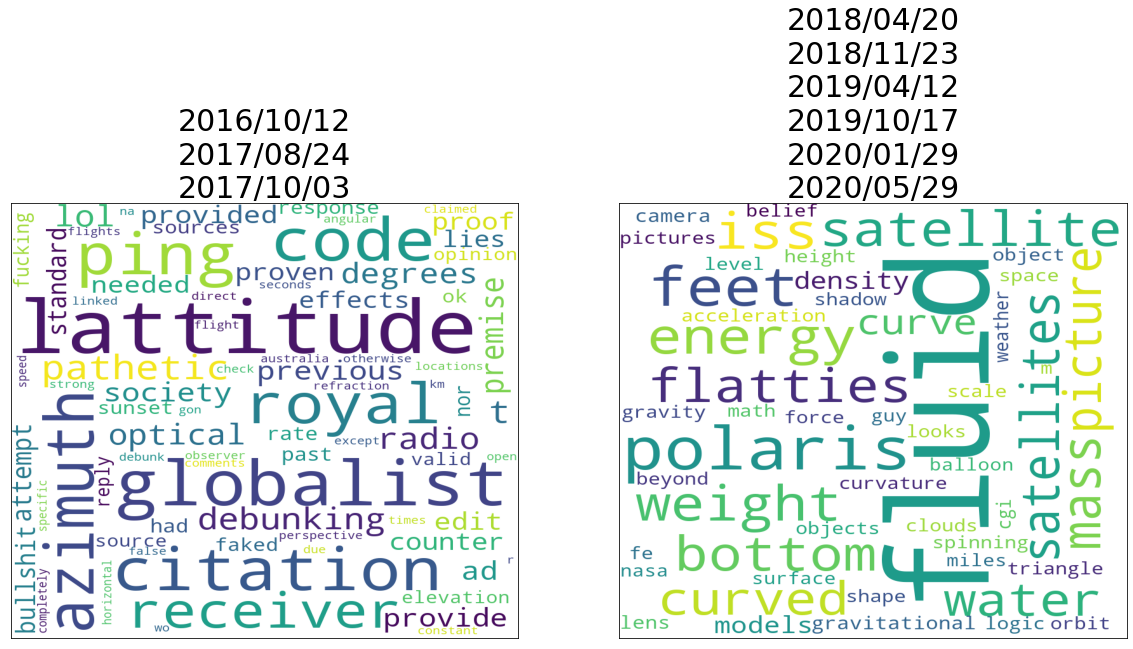

-------------------------------
flatearth


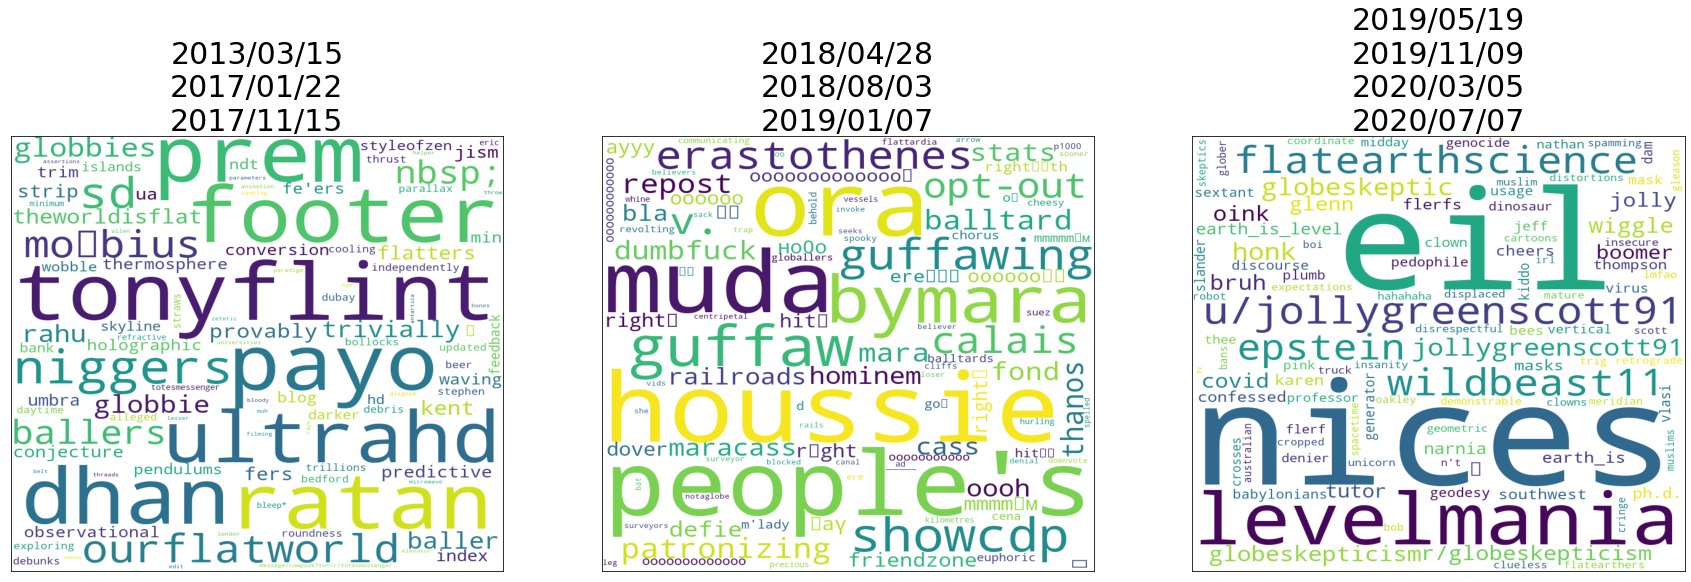

-------------------------------
FlatEarthIsReal


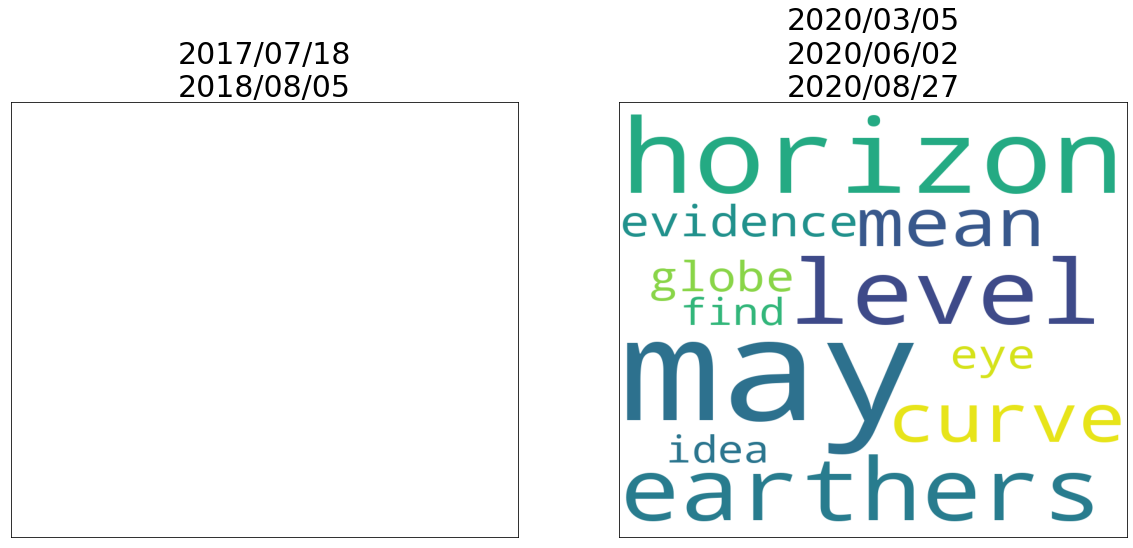

-------------------------------
flatearthsociety


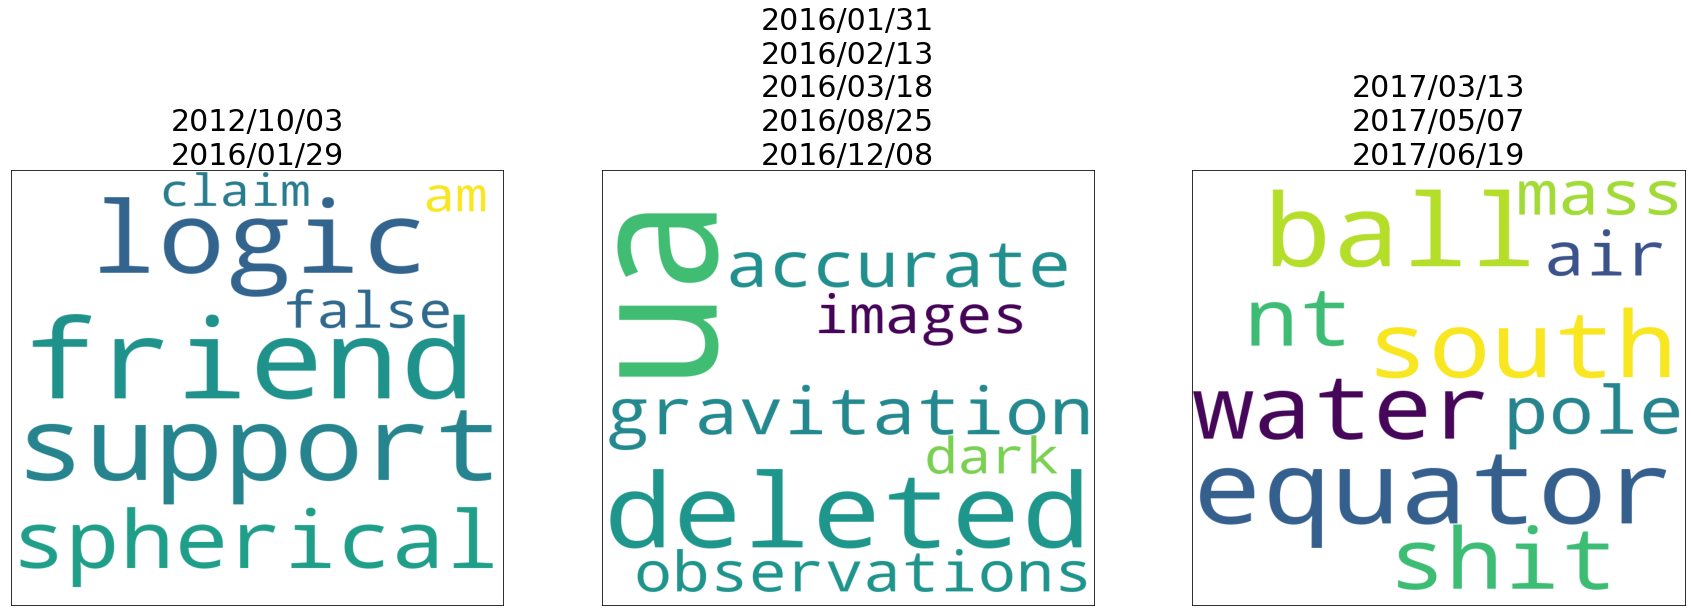

-------------------------------
Flat_Earth


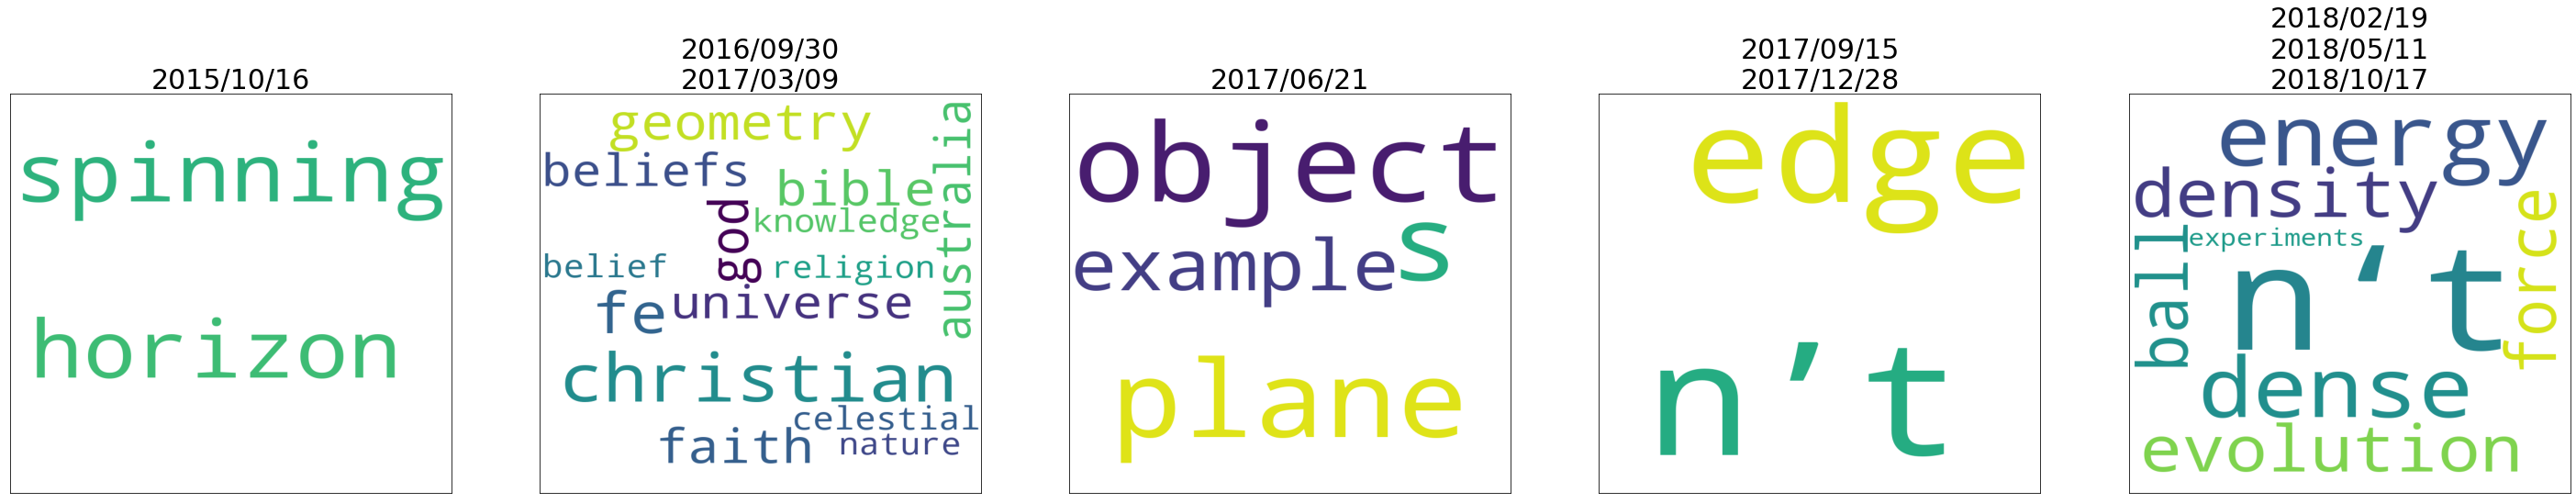

-------------------------------
Globeskeptic


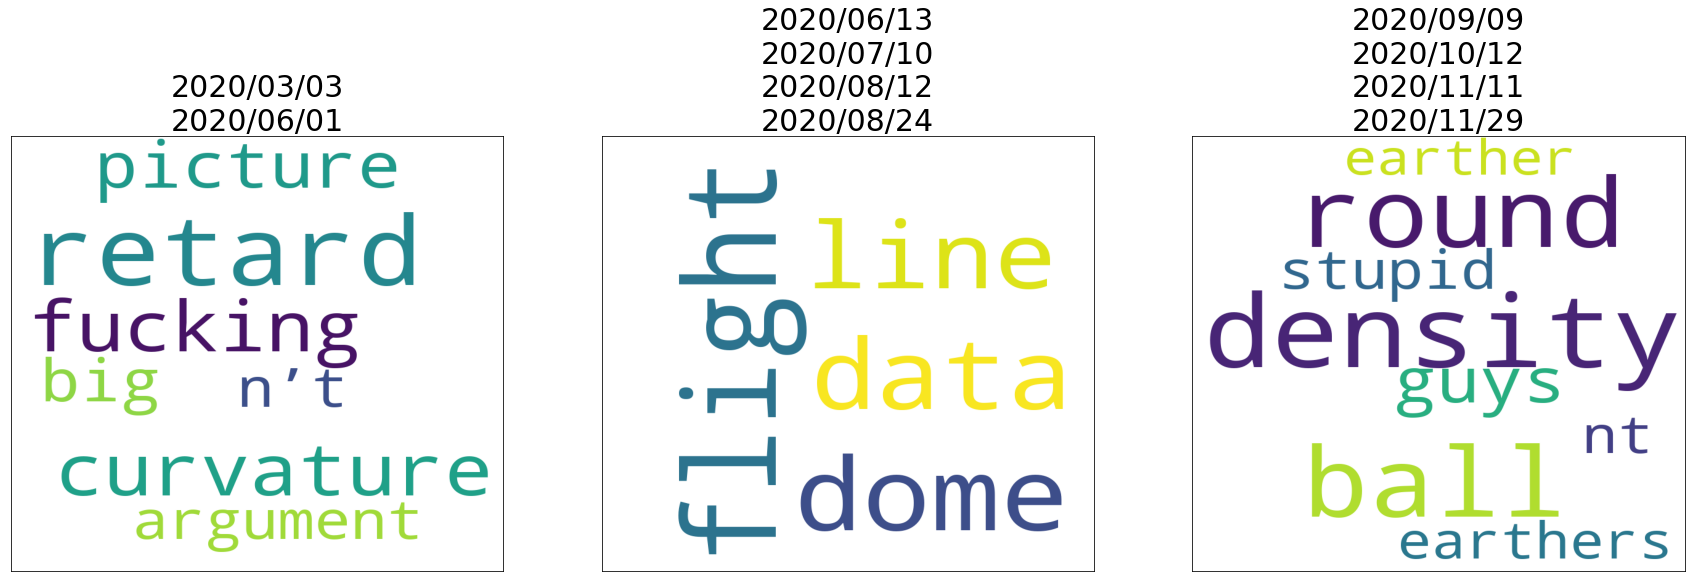

-------------------------------
notaglobe


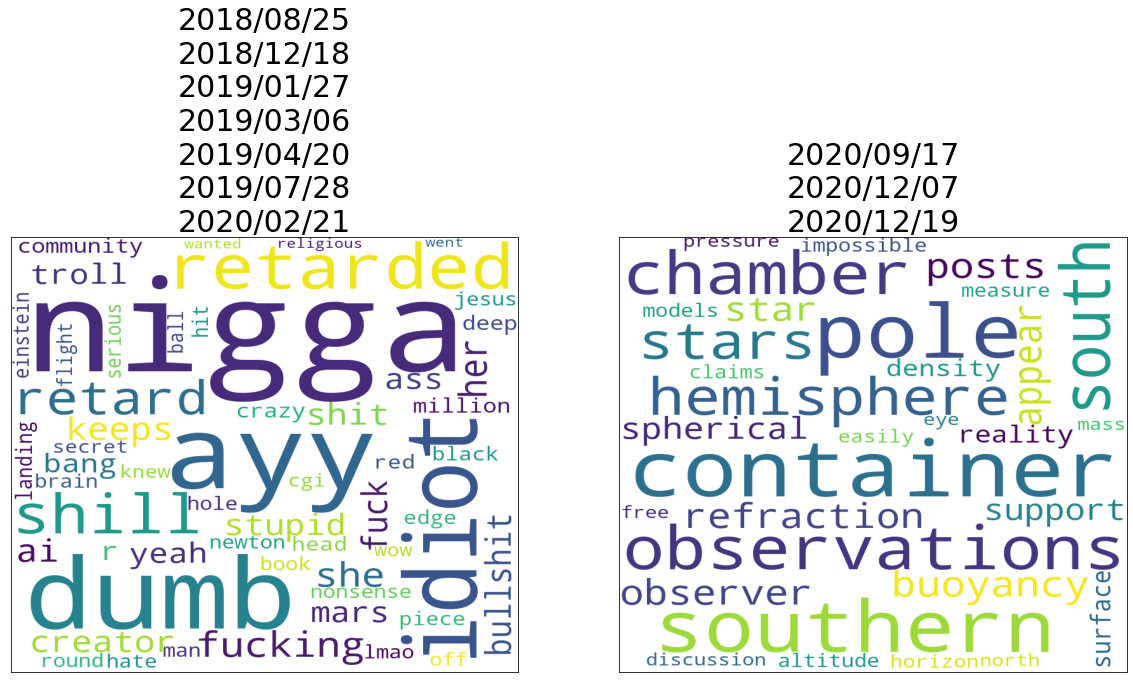

-------------------------------
theworldisflat


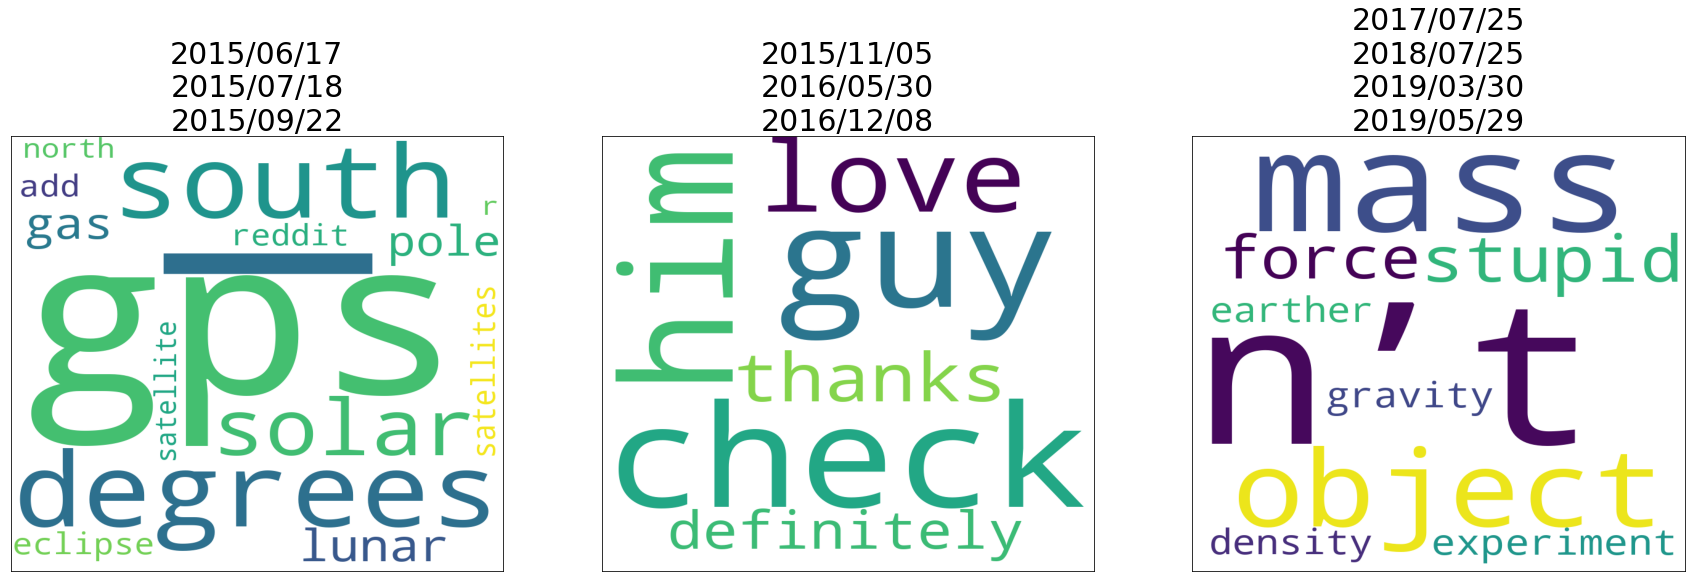

Wall time: 2min 17s


In [96]:
%%time
for sub_name, sub_vnc in vnc_dic.items():
    curr_fp = os.path.join(SUBREDDITS_FP, sub_name, f"{sub_name}.db")
    tok_fp = os.path.join(TOKENS_FP, f"{sub_name}_comments.json")
    
    comments = read_subreddit(curr_fp)
            
    toks = {x[0]: x[1] for x in load_toks(tok_fp)}
    toks = pd.Series(toks)
    toks = toks[toks.index.isin(comments.index)]
    comments = comments.loc[toks.index]
    
    clusters = renumber_cluster(sub_vnc.get_clusters(clust_levels[sub_name]))
    window_posts = {w: curr_posts.index for w, curr_posts in get_data_windows(comments, 
                                                                              window_sizes[sub_name], 
                                                                              window_sizes[sub_name])}
    vnc_windows = sub_vnc.matrix.index

    print("-------------------------------")
    print(sub_name)
    kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows, before_comparison=False)

-------------------------------
DebateFlatEarth


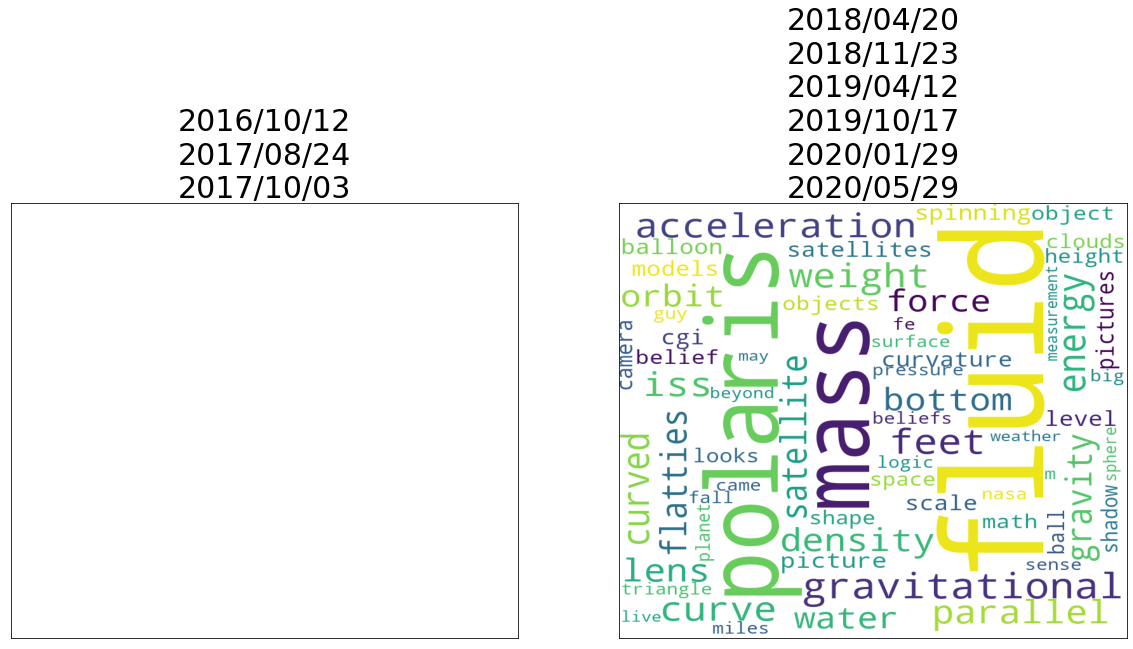

-------------------------------
flatearth


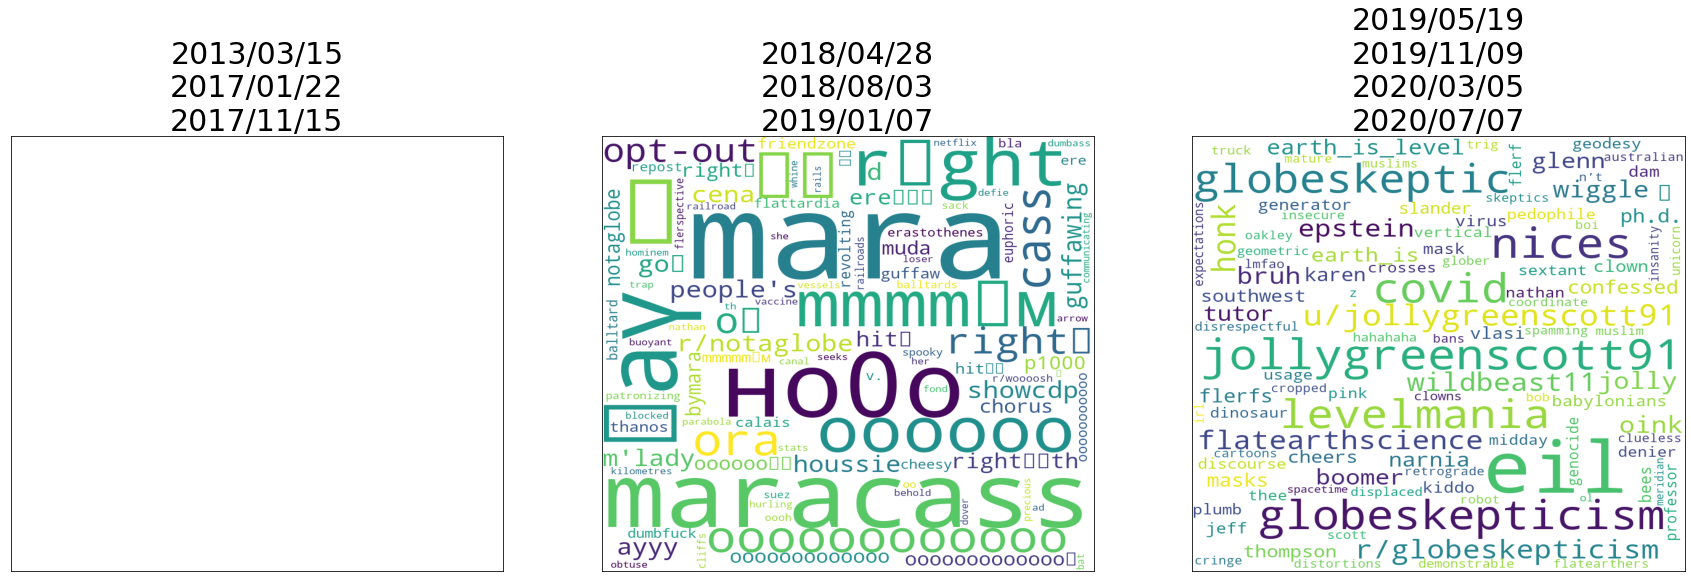

-------------------------------
FlatEarthIsReal


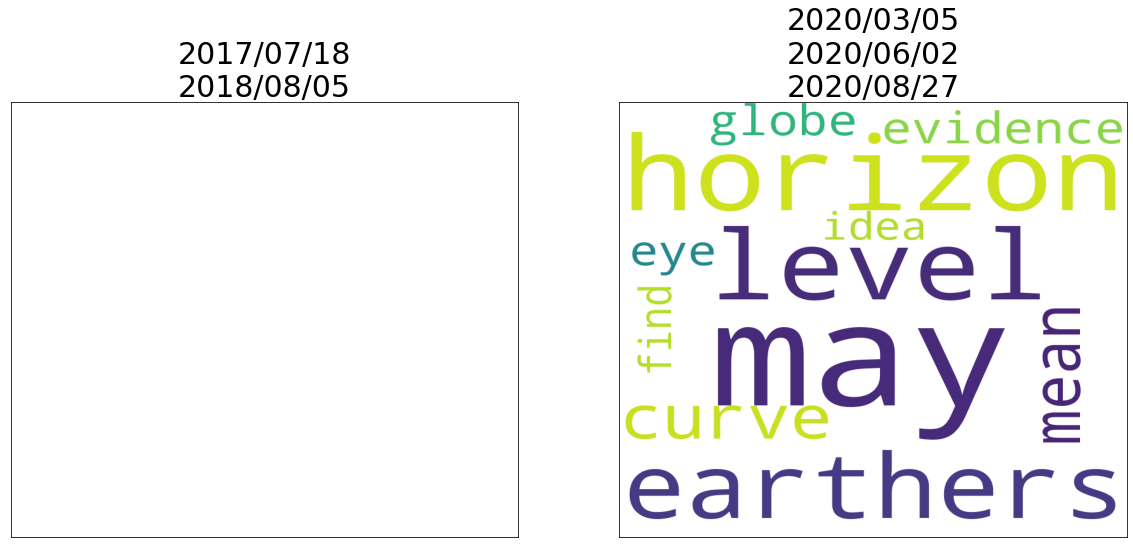

-------------------------------
flatearthsociety


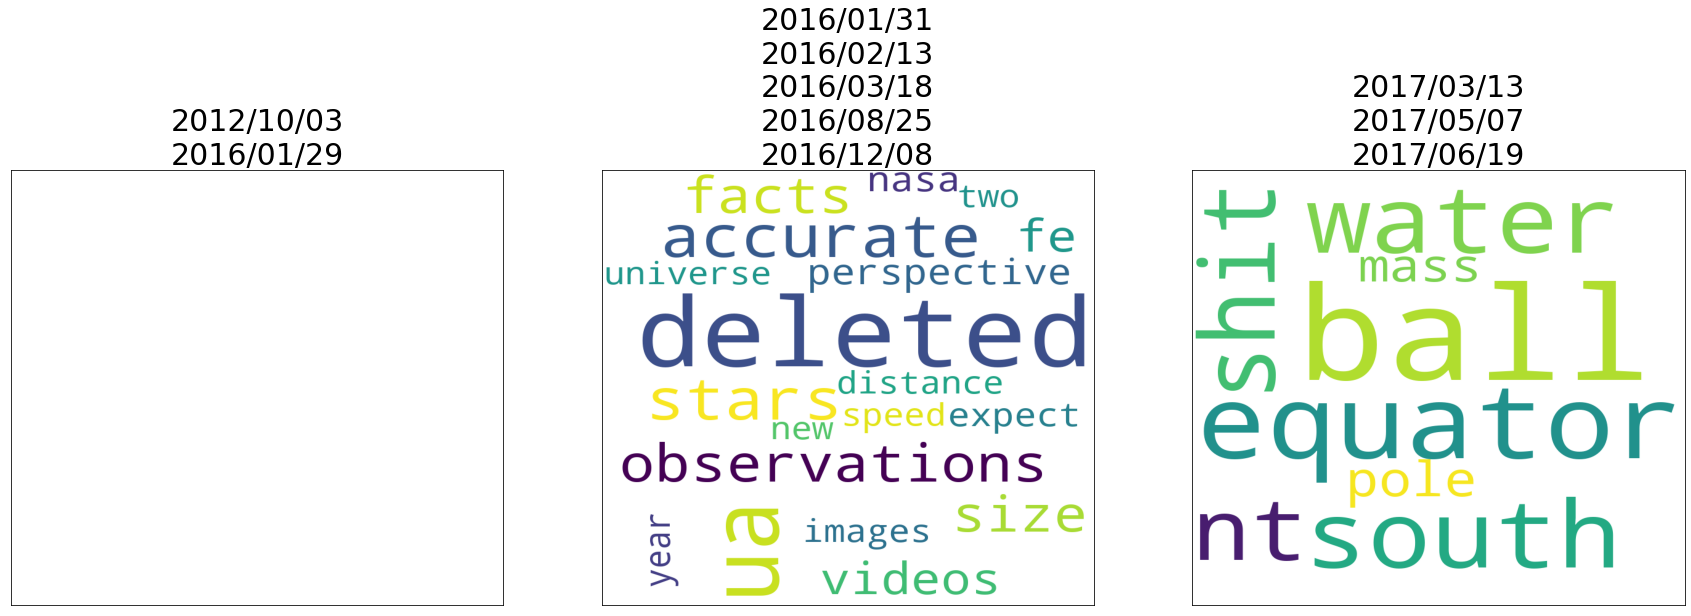

-------------------------------
Flat_Earth


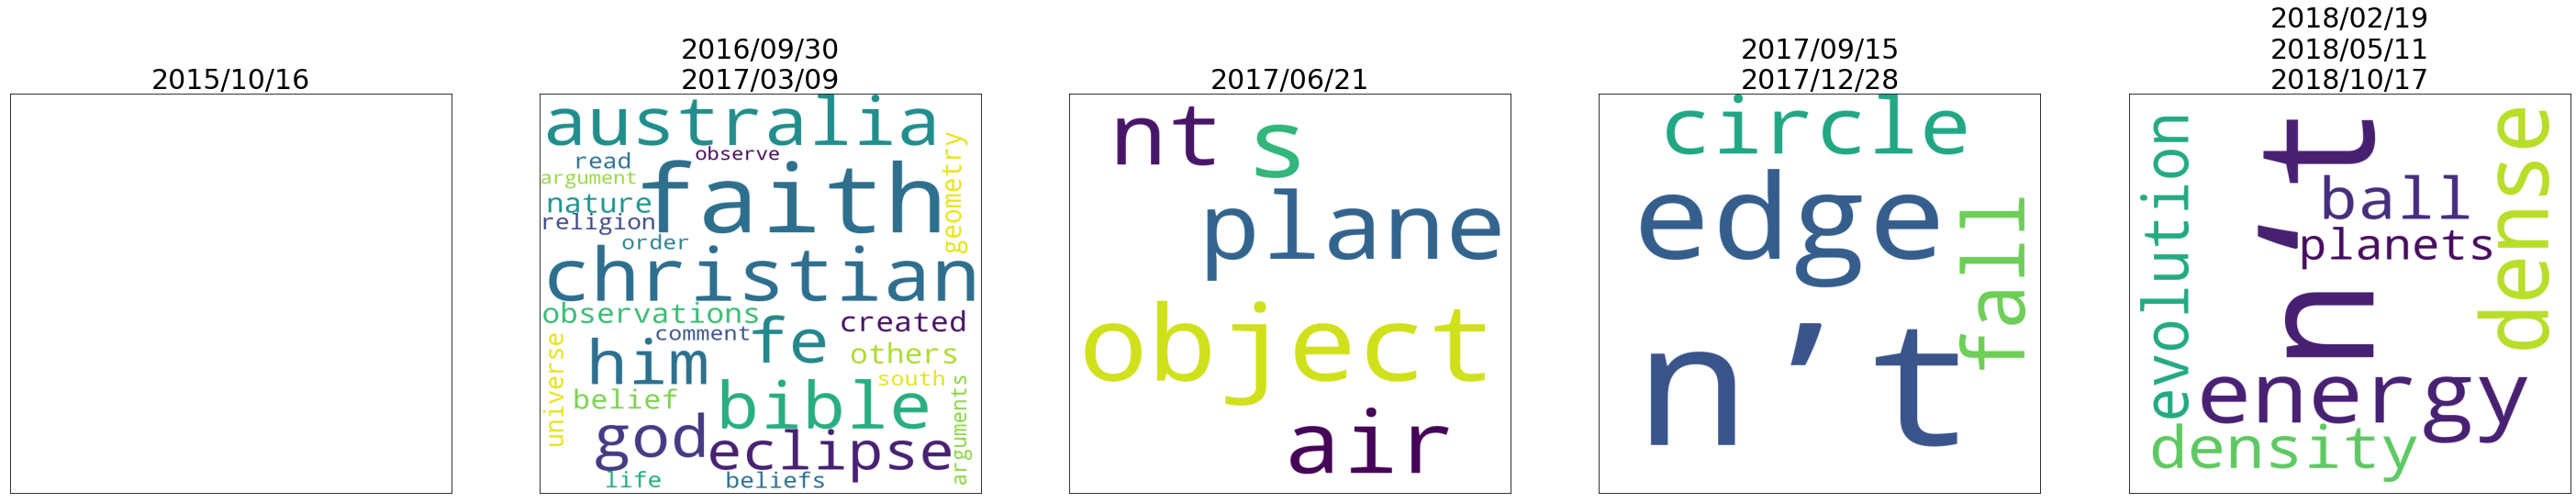

-------------------------------
Globeskeptic


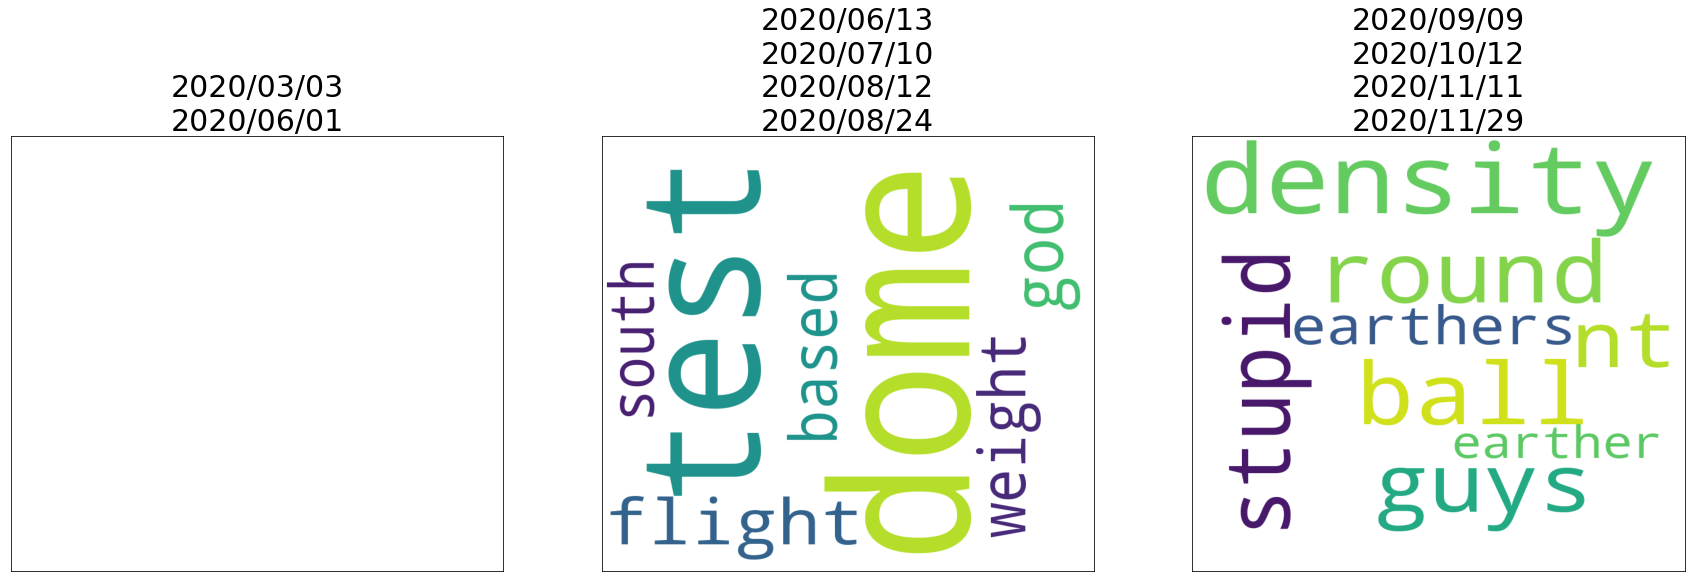

-------------------------------
notaglobe


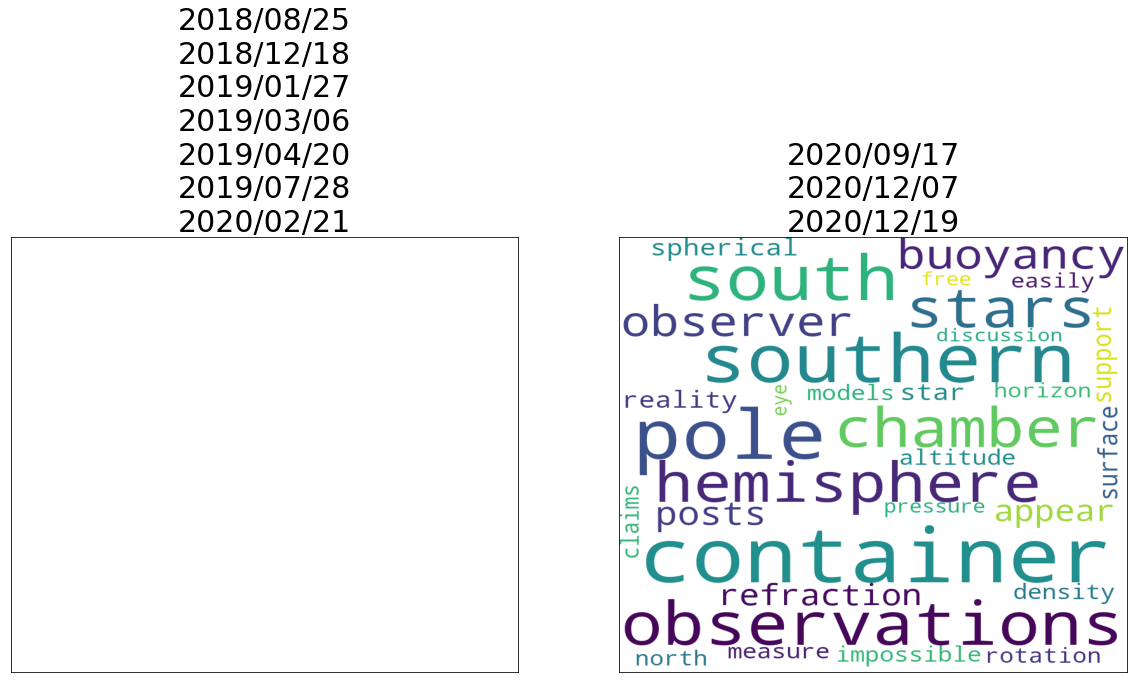

-------------------------------
theworldisflat


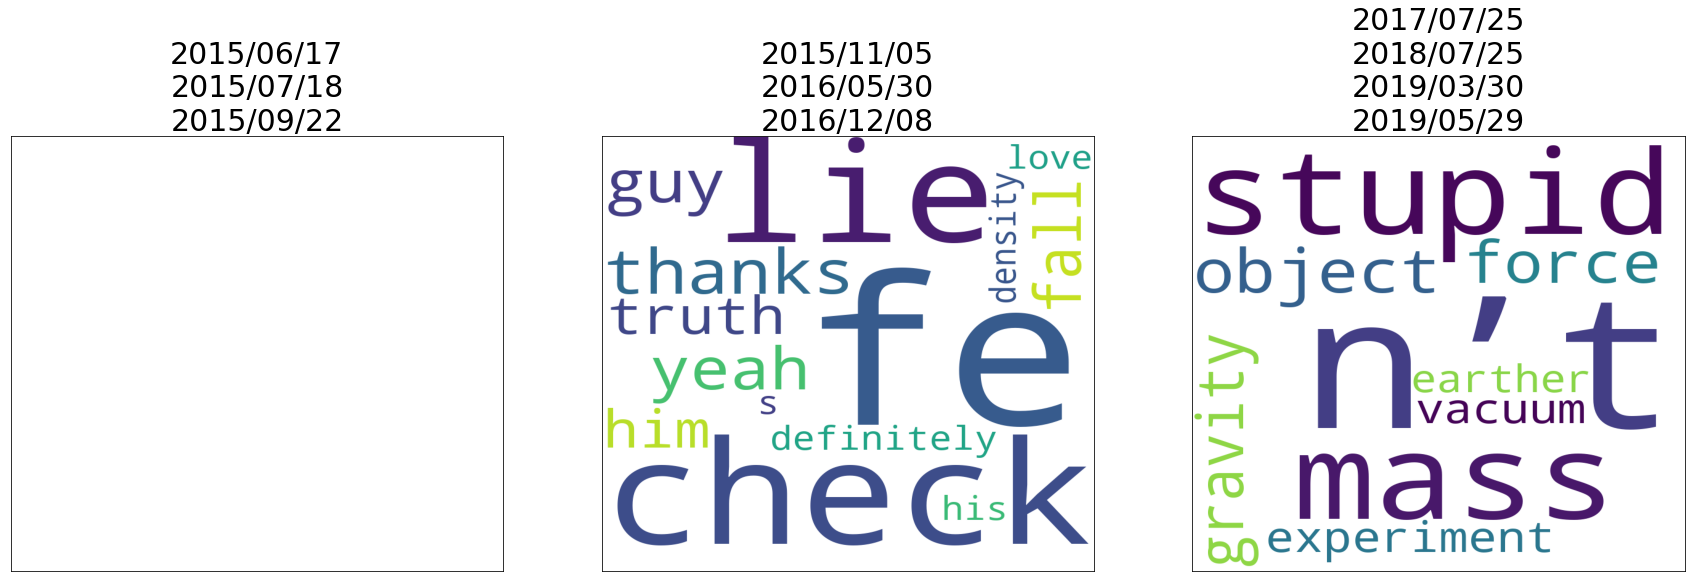

Wall time: 1min 36s


In [97]:
%%time
for sub_name, sub_vnc in vnc_dic.items():
    curr_fp = os.path.join(SUBREDDITS_FP, sub_name, f"{sub_name}.db")
    tok_fp = os.path.join(TOKENS_FP, f"{sub_name}_comments.json")
    
    comments = read_subreddit(curr_fp)
            
    toks = {x[0]: x[1] for x in load_toks(tok_fp)}
    toks = pd.Series(toks)
    toks = toks[toks.index.isin(comments.index)]
    comments = comments.loc[toks.index]
    
    clusters = renumber_cluster(sub_vnc.get_clusters(clust_levels[sub_name]))
    window_posts = {w: curr_posts.index for w, curr_posts in get_data_windows(comments, 
                                                                              window_sizes[sub_name], 
                                                                              window_sizes[sub_name])}
    vnc_windows = sub_vnc.matrix.index

    print("-------------------------------")
    print(sub_name)
    kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows, before_comparison=True)

# Looking at them one at a time

#### r/flatearthsociety

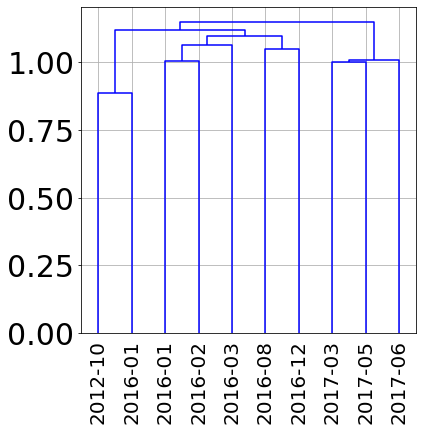

In [67]:
fig, ax = plt.subplots(figsize=(6,6))
vnc_dic["flatearthsociety"].draw_dendrogram(ax=ax, colour="blue")
ax.grid()
plt.show()

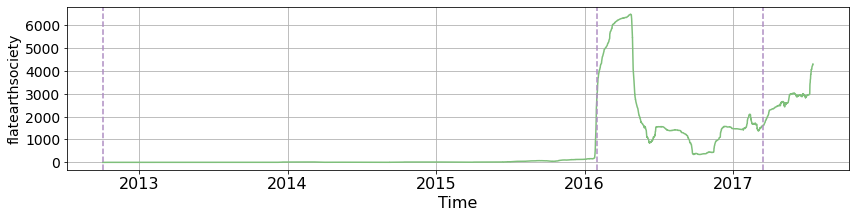

Wall time: 310 ms


In [72]:
%%time
fig, ax = plt.subplots(figsize=(14, 3))

name= "flatearthsociety"
clusts = vnc_dic["flatearthsociety"].get_clusters(1.1)
dates = window_dic[name]
curr_fp = os.path.join(SUBREDDITS_FP, name, f"{name}.db")
comments = read_subreddit(curr_fp)
comments["flag"] = [True] * len(comments)

clust_starts = [dates[clusts==c][0] for c in set(clusts)]
rolling_counts = comments.rolling("90D", on="time").count()
ax_epochs_against_posts(rolling_counts["time"], rolling_counts["flag"], clust_starts, ax) 
ax.set_ylabel(name, size=14)

plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.set_xlabel("Time", size=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
# fig.savefig(os.path.join(OUT_DIR, "fe_reddit_comments_vnc_meta.pdf"))
plt.show()

flatearthsociety


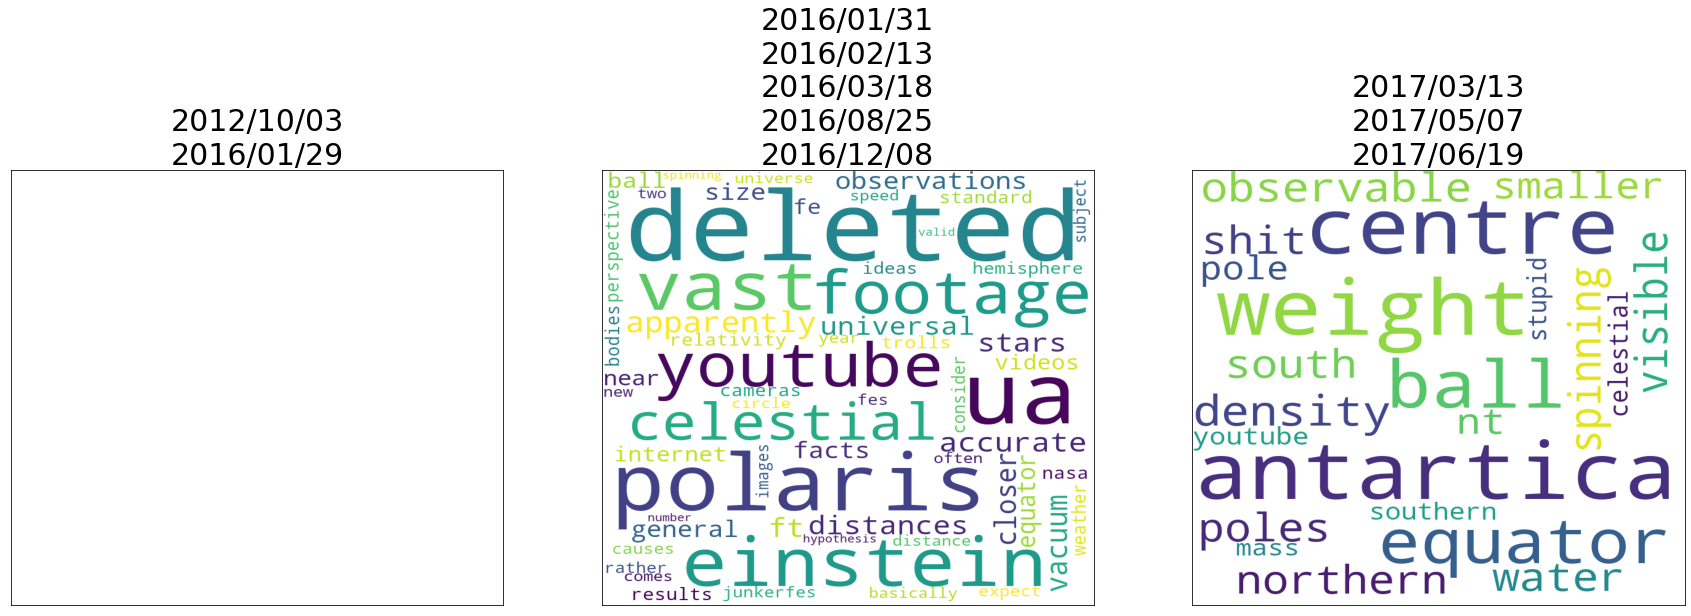

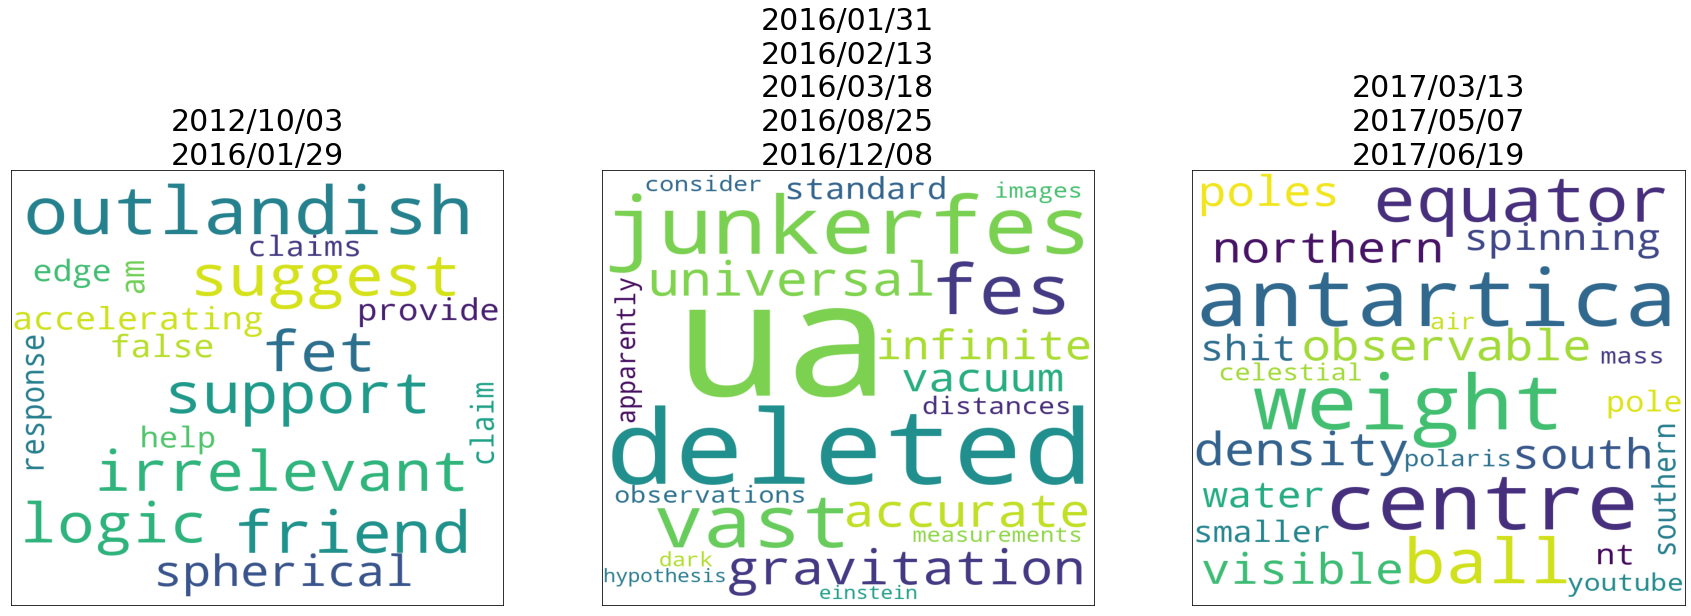

Wall time: 8.66 s


In [79]:
%%time
sub_name="flatearthsociety"
sub_vnc = vnc_dic["flatearthsociety"]
curr_fp = os.path.join(SUBREDDITS_FP, sub_name, f"{sub_name}.db")
tok_fp = os.path.join(TOKENS_FP, f"{sub_name}_comments.json")

comments = read_subreddit(curr_fp)

toks = {x[0]: x[1] for x in load_toks(tok_fp)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(comments.index)]
comments = comments.loc[toks.index]

clusters = renumber_cluster(sub_vnc.get_clusters(1.1))
window_posts = {w: curr_posts.index for w, curr_posts in get_data_windows(comments, 
                                                                          window_sizes[sub_name], 
                                                                          window_sizes[sub_name])}
vnc_windows = sub_vnc.matrix.index

print(sub_name)
kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows, min_freq=50, before_comparison=True)
kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows, min_freq=50, before_comparison=False)

#### r/theworldisflat

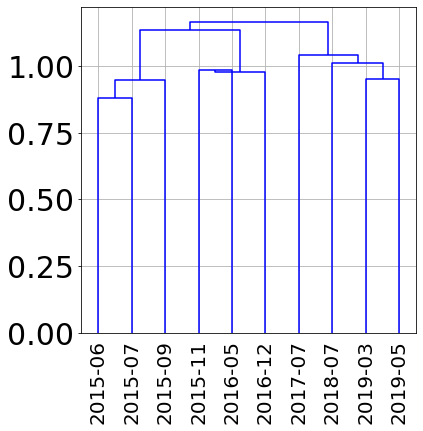

In [83]:
fig, ax = plt.subplots(figsize=(6,6))
vnc_dic["theworldisflat"].draw_dendrogram(ax=ax, colour="blue")
ax.grid()
plt.show()

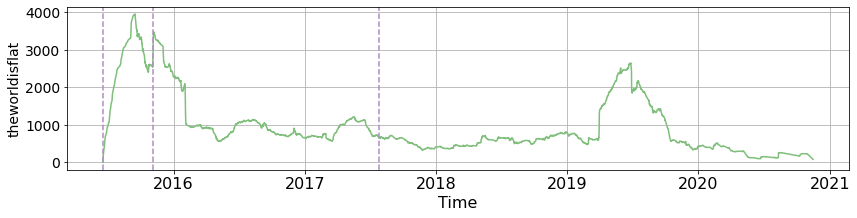

Wall time: 456 ms


In [84]:
%%time
fig, ax = plt.subplots(figsize=(14, 3))

name= "theworldisflat"
clusts = vnc_dic[name].get_clusters(1.1)
dates = window_dic[name]
curr_fp = os.path.join(SUBREDDITS_FP, name, f"{name}.db")
comments = read_subreddit(curr_fp)
comments["flag"] = [True] * len(comments)

clust_starts = [dates[clusts==c][0] for c in set(clusts)]
rolling_counts = comments.rolling("90D", on="time").count()
ax_epochs_against_posts(rolling_counts["time"], rolling_counts["flag"], clust_starts, ax) 
ax.set_ylabel(name, size=14)

plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.set_xlabel("Time", size=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
# fig.savefig(os.path.join(OUT_DIR, "fe_reddit_comments_vnc_meta.pdf"))
plt.show()

theworldisflat


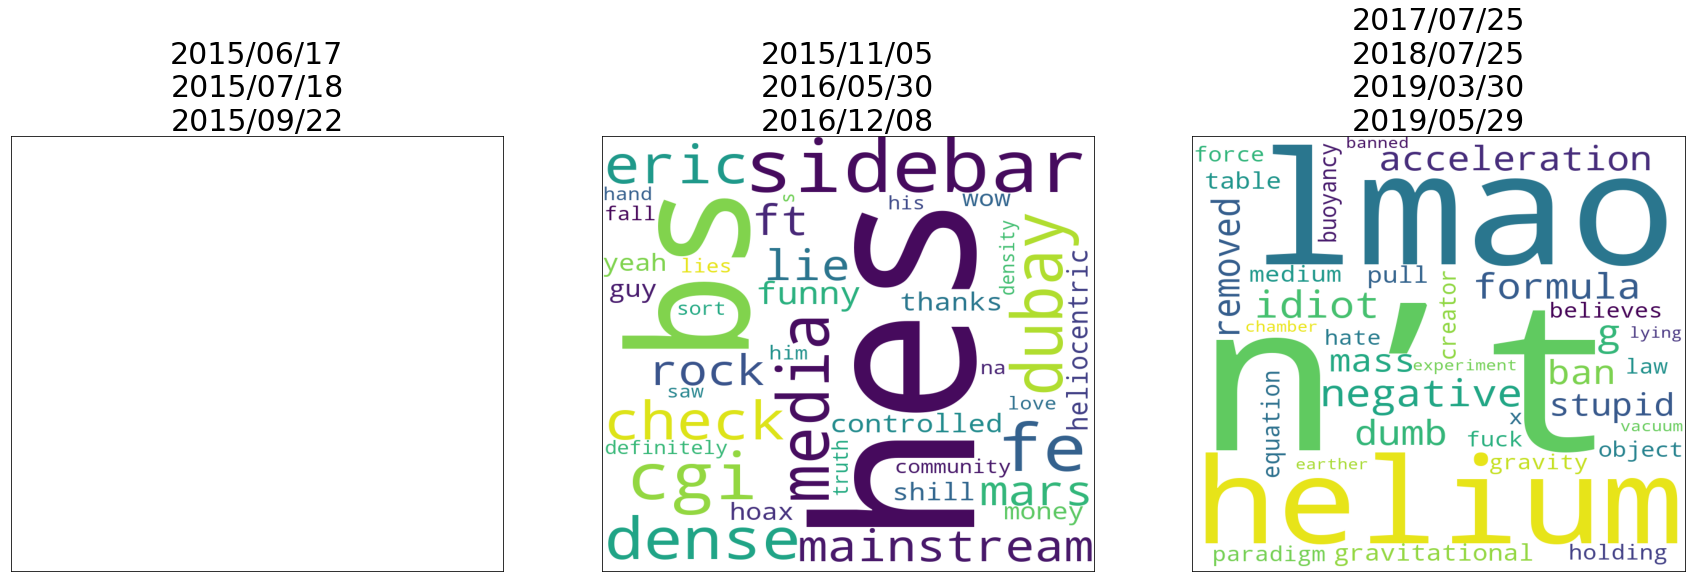

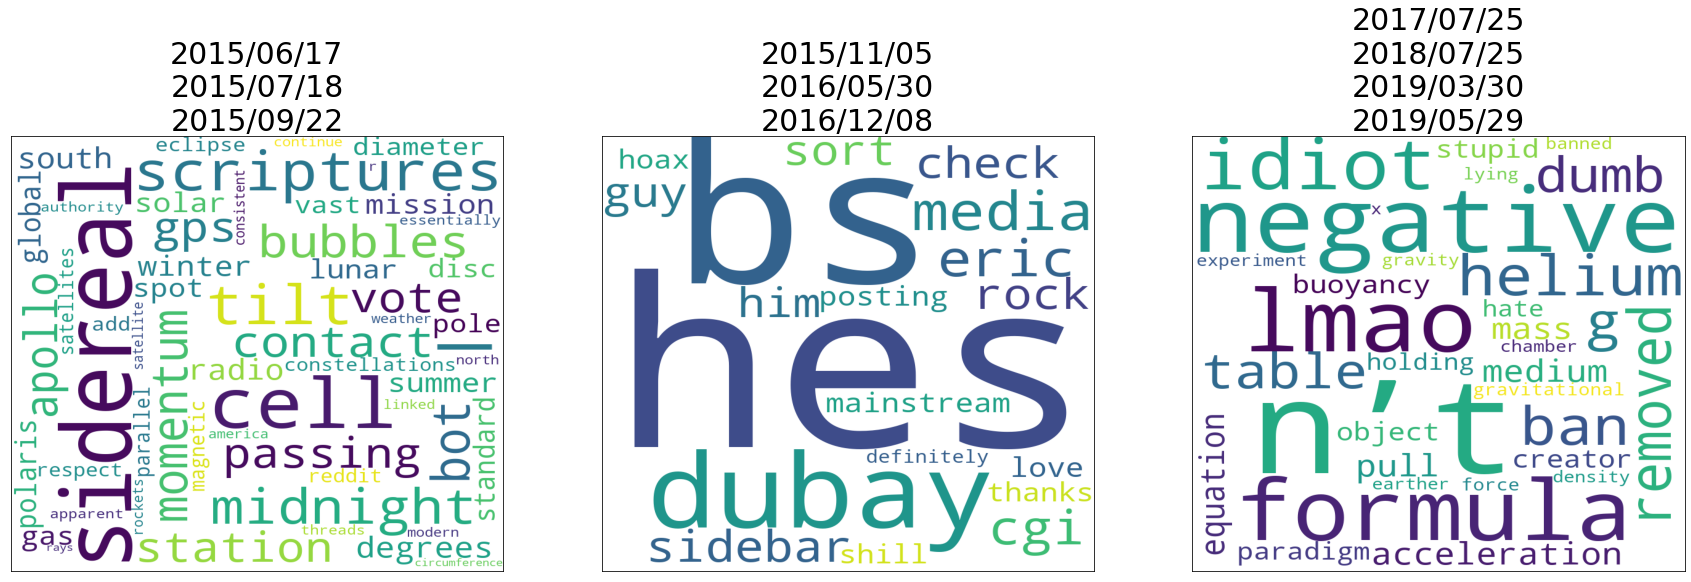

Wall time: 10.5 s


In [85]:
%%time
sub_name="theworldisflat"
sub_vnc = vnc_dic[sub_name]
curr_fp = os.path.join(SUBREDDITS_FP, sub_name, f"{sub_name}.db")
tok_fp = os.path.join(TOKENS_FP, f"{sub_name}_comments.json")

comments = read_subreddit(curr_fp)

toks = {x[0]: x[1] for x in load_toks(tok_fp)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(comments.index)]
comments = comments.loc[toks.index]

clusters = renumber_cluster(sub_vnc.get_clusters(1.1))
window_posts = {w: curr_posts.index for w, curr_posts in get_data_windows(comments, 
                                                                          window_sizes[sub_name], 
                                                                          window_sizes[sub_name])}
vnc_windows = sub_vnc.matrix.index

print(sub_name)
kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows, min_freq=50, before_comparison=True)
kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows, min_freq=50, before_comparison=False)

#### r/notaglobe

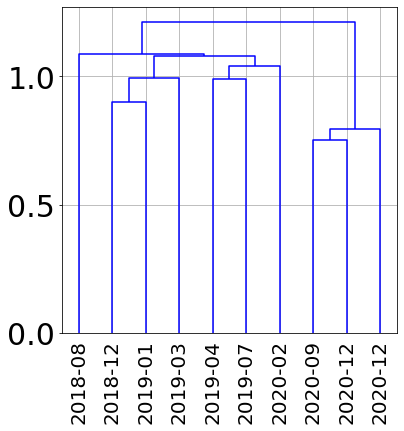

In [80]:
fig, ax = plt.subplots(figsize=(6,6))
vnc_dic["notaglobe"].draw_dendrogram(ax=ax, colour="blue")
ax.grid()
plt.show()

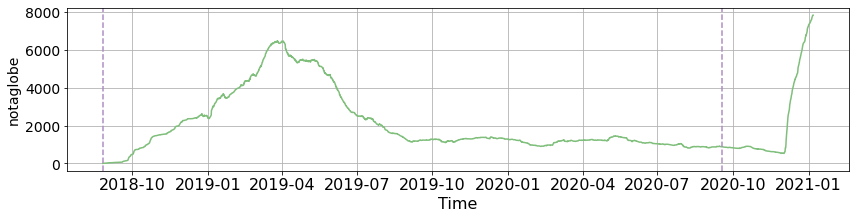

Wall time: 459 ms


In [81]:
%%time
fig, ax = plt.subplots(figsize=(14, 3))

name= "notaglobe"
clusts = vnc_dic[name].get_clusters(1.1)
dates = window_dic[name]
curr_fp = os.path.join(SUBREDDITS_FP, name, f"{name}.db")
comments = read_subreddit(curr_fp)
comments["flag"] = [True] * len(comments)

clust_starts = [dates[clusts==c][0] for c in set(clusts)]
rolling_counts = comments.rolling("90D", on="time").count()
ax_epochs_against_posts(rolling_counts["time"], rolling_counts["flag"], clust_starts, ax) 
ax.set_ylabel(name, size=14)

plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.set_xlabel("Time", size=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
# fig.savefig(os.path.join(OUT_DIR, "fe_reddit_comments_vnc_meta.pdf"))
plt.show()

notaglobe


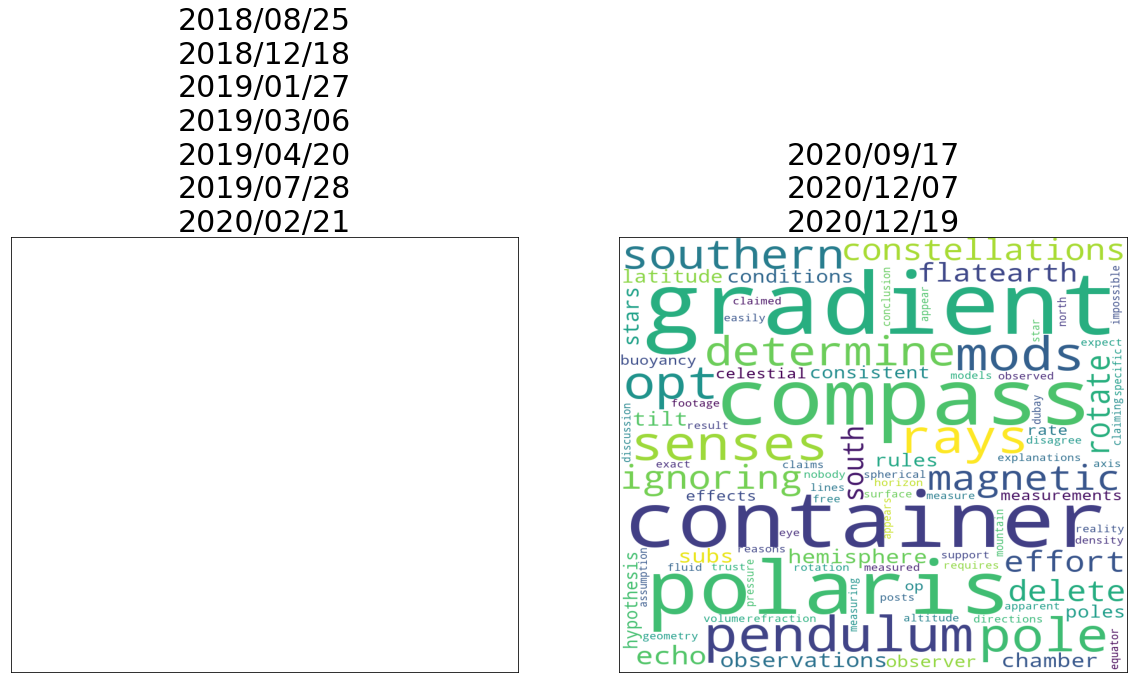

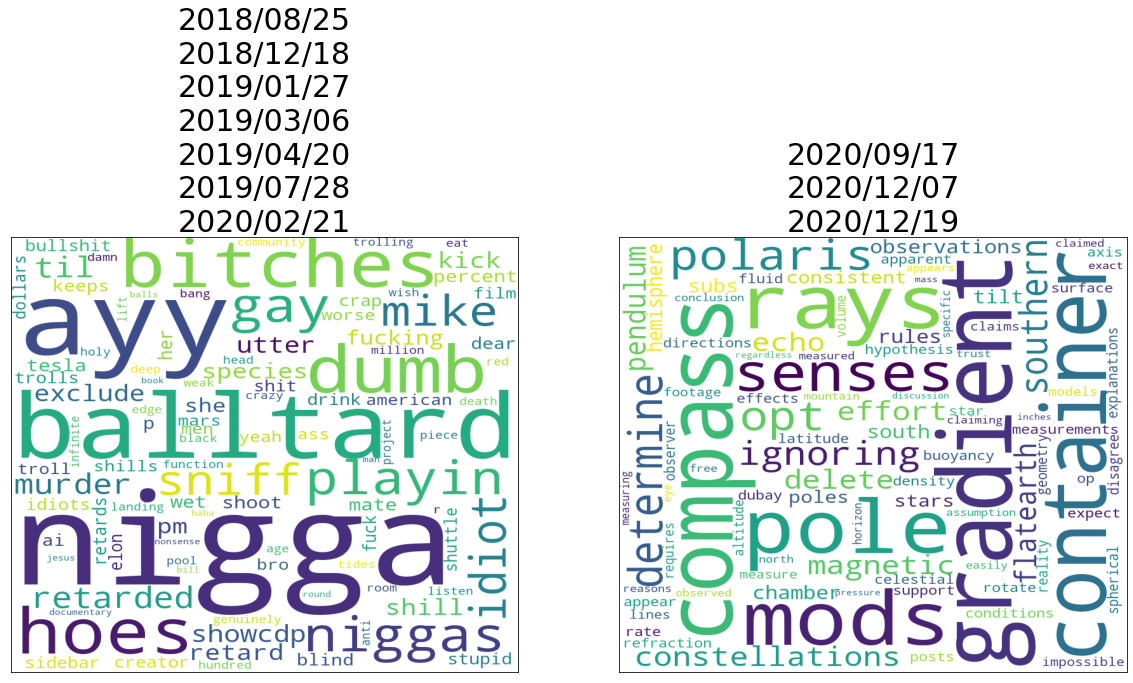

Wall time: 8.54 s


In [82]:
%%time
sub_name="notaglobe"
sub_vnc = vnc_dic[sub_name]
curr_fp = os.path.join(SUBREDDITS_FP, sub_name, f"{sub_name}.db")
tok_fp = os.path.join(TOKENS_FP, f"{sub_name}_comments.json")

comments = read_subreddit(curr_fp)

toks = {x[0]: x[1] for x in load_toks(tok_fp)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(comments.index)]
comments = comments.loc[toks.index]

clusters = renumber_cluster(sub_vnc.get_clusters(1.1))
window_posts = {w: curr_posts.index for w, curr_posts in get_data_windows(comments, 
                                                                          window_sizes[sub_name], 
                                                                          window_sizes[sub_name])}
vnc_windows = sub_vnc.matrix.index

print(sub_name)
kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows, min_freq=50, before_comparison=True)
kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows, min_freq=50, before_comparison=False)